<a href="https://colab.research.google.com/github/gr3g-z/TCC-PUCSP-CDIA/blob/main/StoreSalesTimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STORE SALES

## Extração dos Dados

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

In [3]:
df_test = pd.read_csv('/content/drive/MyDrive/store_sales/test.csv')
df_treino = pd.read_csv('/content/drive/MyDrive/store_sales/train.csv')
transactions = pd.read_csv('/content/drive/MyDrive/store_sales/transactions.csv')
feriados = pd.read_csv('/content/drive/MyDrive/store_sales/holidays_events.csv')
oil = pd.read_csv('/content/drive/MyDrive/store_sales/oil.csv')
stores = pd.read_csv('/content/drive/MyDrive/store_sales/stores.csv')
sample = pd.read_csv('/content/drive/MyDrive/store_sales/sample_submission.csv')

In [4]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [5]:
df = pd.concat([df_treino, df_test], ignore_index=True)
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [6]:
stores = stores.drop(['cluster'], axis =1)
stores.head()

,store_nbr,city,state,type
0,1,Quito,Pichincha,D
1,2,Quito,Pichincha,D
2,3,Quito,Pichincha,D
3,4,Quito,Pichincha,D
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D


## Análise Exploratória

In [7]:
print(f'shape do dataframe de teste: {df.shape}')
#Descarte do dataset de teste por faltar uma coluna importante

shape do dataframe de teste: (3029400, 6)


In [8]:
#Número de lojas
stores['store_nbr'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54])

In [9]:
#Número de Familias
len(df['family'].unique())

33

In [10]:
df['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3029400 entries, 0 to 3029399
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 138.7+ MB


In [12]:
def categoria_predominante(loja):
  '''
  Essa função nos ajuda a ver qual categoria é mais vendida em uma certa loja a sua escolha
  '''
  a = df[df['store_nbr']== loja]
  resultado_groupby = a.groupby(['store_nbr', 'family']).agg({
      'sales': [
          ('count_not_zero', lambda x: (x != 0).sum()),
          ('sum', 'sum'),
          ('mean', 'mean')
      ]
  }).reset_index()
  resultado_groupby.columns = ['store_nbr', 'family', 'count_not_zero', 'sales_sum', 'sales_mean']
  resultado_ordenado = resultado_groupby.sort_values(by='sales_sum', ascending=False)
  pd.options.display.float_format = '{:,.2f}'.format
  resultado_ordenado = resultado_ordenado.reset_index(drop=True)
  return resultado_ordenado

In [13]:
def loja_predominante(categoria):
  '''
  Essa função nos ajuda a ver qual loja é mais predominante em uma certa categoria a sua escolha
  '''
  resultado_groupby = df.groupby(['store_nbr', 'family']).agg({
      'sales': [
          ('count_not_zero', lambda x: (x != 0).sum()),
          ('sum', 'sum'),
          ('mean', 'mean')
      ]
  }).reset_index()
  resultado_groupby.columns = ['store_nbr', 'family', 'count_not_zero', 'sales_sum', 'sales_mean']
  resultado_groupby = resultado_groupby[resultado_groupby['family'] == categoria]

  resultado_ordenado = resultado_groupby.sort_values(by='sales_sum', ascending=False)
  pd.options.display.float_format = '{:,.2f}'.format
  resultado_ordenado = resultado_ordenado.reset_index(drop=True)
  return resultado_ordenado

In [14]:
# Soma de vendas por loja
soma_vendas_por_loja = df.groupby('store_nbr')['sales'].sum().reset_index(name='soma_vendas')

# Ordenando de forma decrescente
soma_vendas_por_loja = soma_vendas_por_loja.sort_values(by='soma_vendas', ascending=False)

In [15]:
# Contagem de vendas por loja
contagem_vendas_por_loja = transactions.groupby('store_nbr')['transactions'].sum().reset_index(name='contagem_vendas')

# Ordenando de forma decrescente
contagem_vendas_por_loja = contagem_vendas_por_loja.sort_values(by='contagem_vendas', ascending=False)

In [16]:
lista_dias_com_dados = []
for i in range(1,55):
  resultado = categoria_predominante(i)

  # Acessar a coluna 'count_not_zero' da primeira instância e salvar os valores em uma lista
  primeira_instancia_count_not_zero = resultado.loc[0, 'count_not_zero']
  lista_dias_com_dados.append(primeira_instancia_count_not_zero)

In [17]:
data = {'loja': soma_vendas_por_loja['store_nbr'],
        'Soma vendas totais': soma_vendas_por_loja['soma_vendas'],
        'Contagem vendas totais': contagem_vendas_por_loja['contagem_vendas'],
        'Media por venda': soma_vendas_por_loja['soma_vendas']/contagem_vendas_por_loja['contagem_vendas'],
        'Dias com dados': lista_dias_com_dados}

In [18]:
df_lojas = pd.DataFrame(data)
df_lojas['Media do faturamento por dia'] = df_lojas['Soma vendas totais']/df_lojas['Dias com dados']
df_lojas['Media de vendas por dia'] = df_lojas['Contagem vendas totais']/df_lojas['Dias com dados']
df_lojas

,loja,Soma vendas totais,Contagem vendas totais,Media por venda,Dias com dados,Media do faturamento por dia,Media de vendas por dia
0,1,"14,145,012.87",2553963,5.54,1694,"8,350.07","1,507.65"
1,2,"21,557,388.64",3219901,6.70,1694,"12,725.73","1,900.77"
2,3,"50,481,910.19",5366350,9.41,1695,"29,782.84","3,165.99"
3,4,"18,909,700.38",2519007,7.51,1695,"11,156.17","1,486.14"
4,5,"15,592,404.57",2347877,6.64,1695,"9,199.06","1,385.18"
5,6,"25,183,680.00",3065896,8.21,1695,"14,857.63","1,808.79"
6,7,"26,952,049.58",2995993,9.00,1695,"15,900.91","1,767.55"
7,8,"30,494,286.93",4637971,6.57,1695,"17,990.73","2,736.27"
8,9,"26,409,441.06",3516162,7.51,1695,"15,580.79","2,074.43"
9,10,"9,613,905.74",1652493,5.82,1695,"5,671.92",974.92


In [19]:
# Renomeando a coluna "Nome" para "NomeCompleto"
stores = stores.rename(columns={'store_nbr': 'loja'})
df_analysis = df_lojas

In [20]:
# Mesclar os dataframes usando a coluna "numero_loja" como chave
df_analysis = pd.merge(df_analysis, stores, on='loja', how='left')

In [21]:
df_analysis['loja'] = df_analysis['loja'].astype('object')
df_analysis = df_analysis.drop(['type'], axis =1)

In [22]:
# Ordenando por vendas (sales) do maior para o menor
df_analysis = df_analysis.sort_values(by='Media de vendas por dia', ascending=False).reset_index(drop=True)

In [23]:
# Criando uma coluna de ID usando a função range
df_analysis['id'] = range(1, len(df_analysis) + 1)

In [24]:
df_analysis

,loja,Soma vendas totais,Contagem vendas totais,Media por venda,Dias com dados,Media do faturamento por dia,Media de vendas por dia,city,state,id
0,44,"62,087,553.25",7273093,8.54,1695,"36,629.82","4,290.91",Quito,Pichincha,1
1,47,"50,948,310.06",6535810,7.80,1695,"30,058.00","3,855.94",Quito,Pichincha,2
2,45,"54,498,010.42",6201115,8.79,1695,"32,152.22","3,658.47",Quito,Pichincha,3
3,46,"41,896,062.12",5990113,6.99,1695,"24,717.44","3,533.99",Quito,Pichincha,4
4,3,"50,481,910.19",5366350,9.41,1695,"29,782.84","3,165.99",Quito,Pichincha,5
5,48,"35,933,130.27",5107785,7.03,1695,"21,199.49","3,013.44",Quito,Pichincha,6
6,8,"30,494,286.93",4637971,6.57,1695,"17,990.73","2,736.27",Quito,Pichincha,7
7,49,"43,420,095.78",4574103,9.49,1695,"25,616.58","2,698.59",Quito,Pichincha,8
8,50,"28,653,020.62",4384444,6.54,1695,"16,904.44","2,586.69",Ambato,Tungurahua,9
9,11,"28,325,558.48",3972488,7.13,1695,"16,711.24","2,343.65",Cayambe,Pichincha,10


In [25]:
df

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0
1,1,2013-01-01,1,BABY CARE,0.00,0
2,2,2013-01-01,1,BEAUTY,0.00,0
3,3,2013-01-01,1,BEVERAGES,0.00,0
4,4,2013-01-01,1,BOOKS,0.00,0
...,...,...,...,...,...,...
3029395,3029395,2017-08-31,9,POULTRY,NaN,1
3029396,3029396,2017-08-31,9,PREPARED FOODS,NaN,0
3029397,3029397,2017-08-31,9,PRODUCE,NaN,1
3029398,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9


In [26]:
df_analysis.to_csv('df_analysis.csv', index=False)

In [27]:
import pickle

with open("df_analysis.pkl", "wb") as fp:   # Pickling
    pickle.dump(df_analysis, fp)

In [28]:
top_df_analysis = df_analysis.head(15)

In [29]:
import plotly.express as px

# Supondo que 'lojas_agrupadas' seja o DataFrame que você deseja plotar

# Crie uma lista de cores para representar diferentes lojas
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Crie o gráfico de barras com a escala de cores personalizada
fig = px.bar(top_df_analysis, x='id', y='Media de vendas por dia', color='loja', title="Lojas",
             color_discrete_sequence=colors)

fig.show()

## K means


In [30]:
#excluindo os atributos que não serão trabalhados pelo algorítmo
df_pre = df_lojas.drop(['loja', 'Media por venda','Dias com dados','Contagem vendas totais','Soma vendas totais'], axis=1)

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()

df_scaled = scaler.fit_transform(df_pre)

In [32]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_scaled)

labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [33]:
labels

array([0, 2, 1, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 2, 2, 2, 0, 0], dtype=int32)

In [34]:
df_clusterizado = pd.concat([df_lojas, pd.DataFrame({'cluster' : labels})], axis=1)
df_clusterizado

,loja,Soma vendas totais,Contagem vendas totais,Media por venda,Dias com dados,Media do faturamento por dia,Media de vendas por dia,cluster
0,1,"14,145,012.87",2553963,5.54,1694,"8,350.07","1,507.65",0
1,2,"21,557,388.64",3219901,6.70,1694,"12,725.73","1,900.77",2
2,3,"50,481,910.19",5366350,9.41,1695,"29,782.84","3,165.99",1
3,4,"18,909,700.38",2519007,7.51,1695,"11,156.17","1,486.14",0
4,5,"15,592,404.57",2347877,6.64,1695,"9,199.06","1,385.18",0
5,6,"25,183,680.00",3065896,8.21,1695,"14,857.63","1,808.79",2
6,7,"26,952,049.58",2995993,9.00,1695,"15,900.91","1,767.55",2
7,8,"30,494,286.93",4637971,6.57,1695,"17,990.73","2,736.27",2
8,9,"26,409,441.06",3516162,7.51,1695,"15,580.79","2,074.43",2
9,10,"9,613,905.74",1652493,5.82,1695,"5,671.92",974.92,0


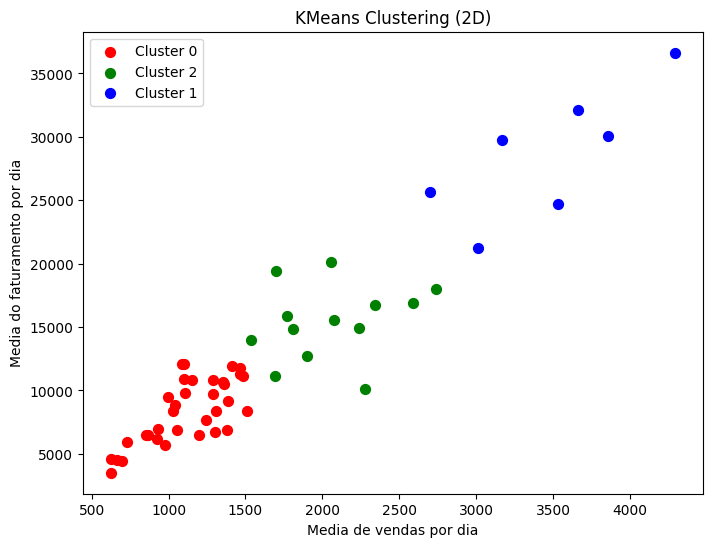

In [35]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Supondo que você já tenha treinado o modelo KMeans e adicionado os rótulos ao DataFrame
# Substitua 'labels' pelo nome da coluna que contém os rótulos de cluster em seu DataFrame.

plt.figure(figsize=(8, 6))

# Mapear cores para clusters
colors = ['red', 'blue', 'green', 'purple', 'orange']

for cluster in df_clusterizado['cluster'].unique():
    cluster_data = df_clusterizado[df_clusterizado['cluster'] == cluster]
    plt.scatter(cluster_data['Media de vendas por dia'], cluster_data['Media do faturamento por dia'],
                label=f'Cluster {cluster}', c=colors[cluster], s=50)  # 'c' define a cor, 's' define o tamanho dos pontos

# Adicionar legendas e título
plt.xlabel('Media de vendas por dia')
plt.ylabel('Media do faturamento por dia')
plt.title('KMeans Clustering (2D)')

# Adicionar legenda
plt.legend()
plt.show()


### Conclusão
* CLUSTER 0 = Empresas de pequeno porte.
* CLUSTER 1 = Empresas de grande porte.
* CLUSTER 2 = Empresas de médio porte.

## Séries Temporais - Facebook Prophet

<ipython-input-36-6808667c870c>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

DEBUG:cmdstanpy:input tempfile: /tmp/tmp54bqg3x6/5kl8v9zu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp54bqg3x6/xkei067i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42226', 'data', 'file=/tmp/tmp54bqg3x6/5kl8v9zu.json', 'init=/tmp/tmp54bqg3x6/xkei067i.json', 'output', 'file=/tmp/tmp54bqg3x6/prophet_modelga0qygap/prophet_model-20240327183917.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:39:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:39:17 - cmd

             ds     yhat  yhat_lower  yhat_upper
0    2013-01-02 3,586.89    3,286.87    3,877.00
1    2013-01-03 3,244.28    2,943.46    3,541.76
2    2013-01-04 3,516.79    3,204.26    3,823.16
3    2013-01-05 3,859.22    3,560.05    4,183.35
4    2013-01-06 3,674.37    3,357.24    3,984.83
...         ...      ...         ...         ...
1851 2018-02-07 3,180.23    2,842.65    3,477.09
1852 2018-02-08 2,907.42    2,594.25    3,207.18
1853 2018-02-09 3,247.94    2,943.12    3,568.37
1854 2018-02-10 3,655.85    3,333.07    3,952.23
1855 2018-02-11 3,533.23    3,218.81    3,822.66

[1856 rows x 4 columns]


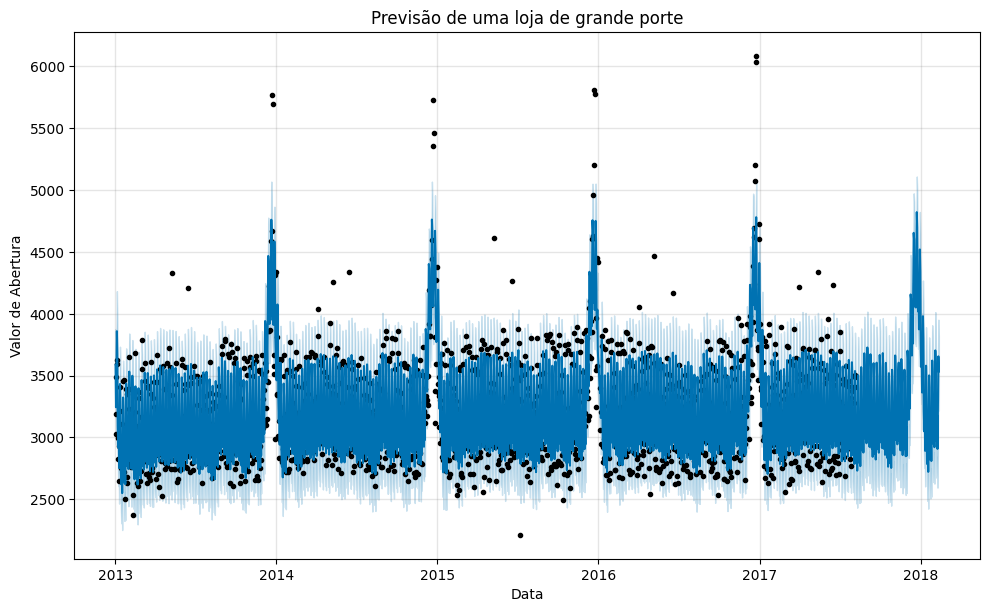

In [36]:
# Criar um novo DataFrame filtrando os valores da coluna "sorte_nbr"
df_novo = transactions[transactions['store_nbr'] ==3]
df_novo['date'] = pd.to_datetime(df_novo['date'])
df_novo
# Substitua 'nome_da_coluna' pelo nome real da coluna que você deseja dropar
nome_da_coluna = 'store_nbr'

# Use o método drop para remover a coluna
df_st = df_novo.drop(nome_da_coluna, axis=1)
df_st = df_st.rename(columns={'date': 'ds', 'transactions': 'y'})
df_st

# Crie e ajuste o modelo Prophet
model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
model.add_country_holidays(country_name='US')
model.fit(df_st)

# Crie um DataFrame para as datas futuras que você deseja prever
future = model.make_future_dataframe(periods=180)  # 60 dias no futuro

# Faça as previsões para as datas futuras
forecast = model.predict(future)

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

# Visualize as previsões
fig = model.plot(forecast)
plt.title('Previsão de uma loja de grande porte')
plt.xlabel('Data')
plt.ylabel('Valor de Abertura')
plt.show()

<ipython-input-37-28dc323ad637>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

DEBUG:cmdstanpy:input tempfile: /tmp/tmp54bqg3x6/_87dy2hj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp54bqg3x6/vphmuy_y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25225', 'data', 'file=/tmp/tmp54bqg3x6/_87dy2hj.json', 'init=/tmp/tmp54bqg3x6/vphmuy_y.json', 'output', 'file=/tmp/tmp54bqg3x6/prophet_modeljfw_ewv5/prophet_model-20240327183920.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:39:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:39:21 - cmd

             ds     yhat  yhat_lower  yhat_upper
0    2013-01-02 2,207.04    2,000.31    2,418.34
1    2013-01-03 2,025.24    1,825.94    2,235.89
2    2013-01-04 2,106.26    1,892.64    2,319.19
3    2013-01-05 2,205.96    2,008.17    2,406.93
4    2013-01-06 2,062.67    1,849.64    2,277.68
...         ...      ...         ...         ...
1852 2018-02-07 1,922.01    1,718.58    2,133.44
1853 2018-02-08 1,773.12    1,557.81    1,976.57
1854 2018-02-09 1,886.14    1,671.80    2,097.68
1855 2018-02-10 2,016.60    1,804.50    2,240.37
1856 2018-02-11 1,902.50    1,696.40    2,110.95

[1857 rows x 4 columns]


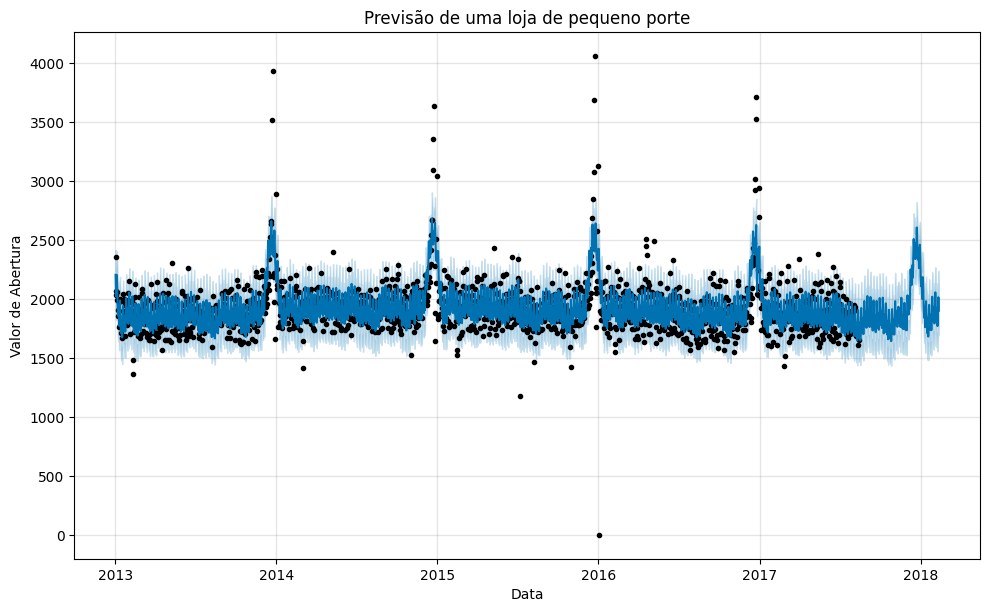

In [37]:
# Criar um novo DataFrame filtrando os valores da coluna "sorte_nbr"
df_novo = transactions[transactions['store_nbr'] ==2]
df_novo['date'] = pd.to_datetime(df_novo['date'])
df_novo
# Substitua 'nome_da_coluna' pelo nome real da coluna que você deseja dropar
nome_da_coluna = 'store_nbr'

# Use o método drop para remover a coluna
df_st = df_novo.drop(nome_da_coluna, axis=1)
df_st = df_st.rename(columns={'date': 'ds', 'transactions': 'y'})
df_st

# Crie e ajuste o modelo Prophet
model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
model.add_country_holidays(country_name='US')
model.fit(df_st)

# Crie um DataFrame para as datas futuras que você deseja prever
future = model.make_future_dataframe(periods=180)  # 60 dias no futuro

# Faça as previsões para as datas futuras
forecast = model.predict(future)

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

# Visualize as previsões
fig = model.plot(forecast)
plt.title('Previsão de uma loja de pequeno porte')
plt.xlabel('Data')
plt.ylabel('Valor de Abertura')
plt.show()

## Séries Temporais - SARIMA

In [38]:
pip install pmdarima

In [39]:
df_sarGP = transactions[transactions['store_nbr'] ==3]
df_sarGP['date'] = pd.to_datetime(df_sarGP['date'])

<ipython-input-39-632e9546b7fb>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [40]:
df_sarGP

,date,store_nbr,transactions
3,2013-01-02,3,3487
49,2013-01-03,3,3026
95,2013-01-04,3,3188
141,2013-01-05,3,3623
187,2013-01-06,3,3590
...,...,...,...
83220,2017-08-11,3,2991
83274,2017-08-12,3,3070
83328,2017-08-13,3,3075
83382,2017-08-14,3,3036


In [41]:
df_sarGP = df_sarGP.reset_index()

df_sarGP = df_sarGP.drop(['index', 'store_nbr'], axis =1)

In [42]:
df_sarGP

,date,transactions
0,2013-01-02,3487
1,2013-01-03,3026
2,2013-01-04,3188
3,2013-01-05,3623
4,2013-01-06,3590
...,...,...
1671,2017-08-11,2991
1672,2017-08-12,3070
1673,2017-08-13,3075
1674,2017-08-14,3036


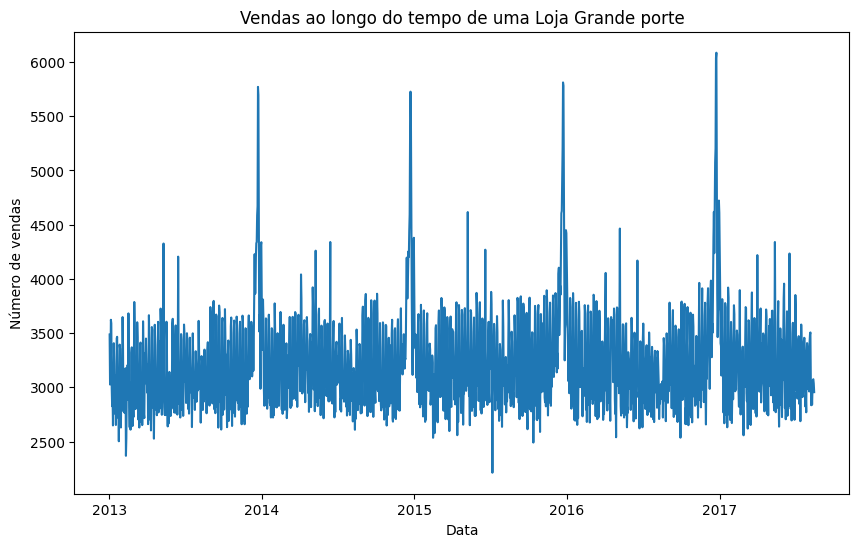

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX



# Visualização dos dados
plt.figure(figsize=(10, 6))
plt.plot(df_sarGP['date'], df_sarGP['transactions'])
plt.title('Vendas ao longo do tempo de uma Loja Grande porte')
plt.xlabel('Data')
plt.ylabel('Número de vendas')
plt.show()


In [44]:
# Verificcao do melhor setup de order e seasonal order possivel para o modelo.
#modelo_auto_GP = auto_arima(df_sarGP['transactions'], seasonal=True, m=7, trace=True)

# Visualizar os melhores parâmetros encontrados
#print(modelo_auto_GP.summary())

In [45]:
# Salvar o resultado de modelo_auto.summary_GP() em um arquivo pickle
#with open('modelo_auto_summary_GP.pickle', 'wb') as f:
    #pickle.dump(modelo_auto_GP.summary(), f)

In [46]:
# Carregar o arquivo pickle
with open('/content/drive/MyDrive/store_sales/modelo_auto_summary_GP.pickle', 'rb') as f:
    modelo_auto_summary_GP = pickle.load(f)

# Agora você pode usar modelo_auto_summary como desejado
print(modelo_auto_summary_GP)

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1676
Model:             SARIMAX(5, 1, 0)x(1, 0, [1], 7)   Log Likelihood              -11639.936
Date:                             Mon, 25 Mar 2024   AIC                          23295.872
Time:                                     21:32:25   BIC                          23339.261
Sample:                                          0   HQIC                         23311.947
                                            - 1676                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3071      0.014    -21.276      0.000      -0.335      -0.279
ar.L2         -0.4066      

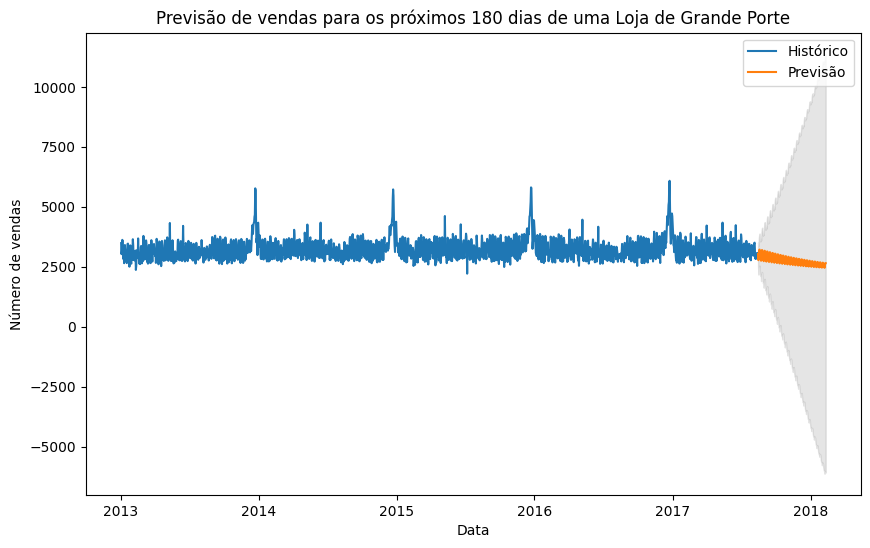

In [47]:
# Ajuste do modelo SARIMA
model = SARIMAX(df_sarGP['transactions'], order=(5, 1, 0), seasonal_order=(1, 0, 1, 7))
result = model.fit()

# Previsão dos próximos 180 dias
forecast = result.get_forecast(steps=180)

# Visualização da previsão
plt.figure(figsize=(10, 6))
plt.plot(df_sarGP['date'], df_sarGP['transactions'], label='Histórico')
plt.plot(pd.date_range(start=df_sarGP['date'].max(), periods=180), forecast.predicted_mean, label='Previsão')
plt.fill_between(pd.date_range(start=df_sarGP['date'].max(), periods=180),
                 forecast.conf_int()['lower transactions'],
                 forecast.conf_int()['upper transactions'], color='gray', alpha=0.2)
plt.title('Previsão de vendas para os próximos 180 dias de uma Loja de Grande Porte')
plt.xlabel('Data')
plt.ylabel('Número de vendas')
plt.legend()
plt.show()


In [48]:
# Previsao de uma loja de pequeno porte

df_sarPP = transactions[transactions['store_nbr'] ==2]
df_sarPP['date'] = pd.to_datetime(df_sarPP['date'])

<ipython-input-48-1d2b6186c257>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [49]:
# Configuração do auto_arima
#modelo_auto_PP = auto_arima(df_sarPP['transactions'], seasonal=True, m=7, trace=True)

# Visualizar os melhores parâmetros encontrados
#print(modelo_auto_PP.summary())

In [50]:
# Salvar o resultado de modelo_auto.summary_PP() em um arquivo pickle
#with open('modelo_auto_summary_PP.pickle', 'wb') as f:
    #pickle.dump(modelo_auto_PP.summary(), f)

In [51]:
# Carregar o arquivo pickle
with open('/content/drive/MyDrive/store_sales/modelo_auto_summary_PP.pickle', 'rb') as f:
    modelo_auto_summary_PP = pickle.load(f)

# Agora você pode usar modelo_auto_summary como desejado
print(modelo_auto_summary_PP)


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1677
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 7)   Log Likelihood              -11130.962
Date:                           Mon, 25 Mar 2024   AIC                          22269.923
Time:                                   21:42:04   BIC                          22291.622
Sample:                                        0   HQIC                         22277.962
                                          - 1677                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    707.8533     14.971     47.281      0.000     678.511     737.196
ar.L1          0.4732      0.007     67.043

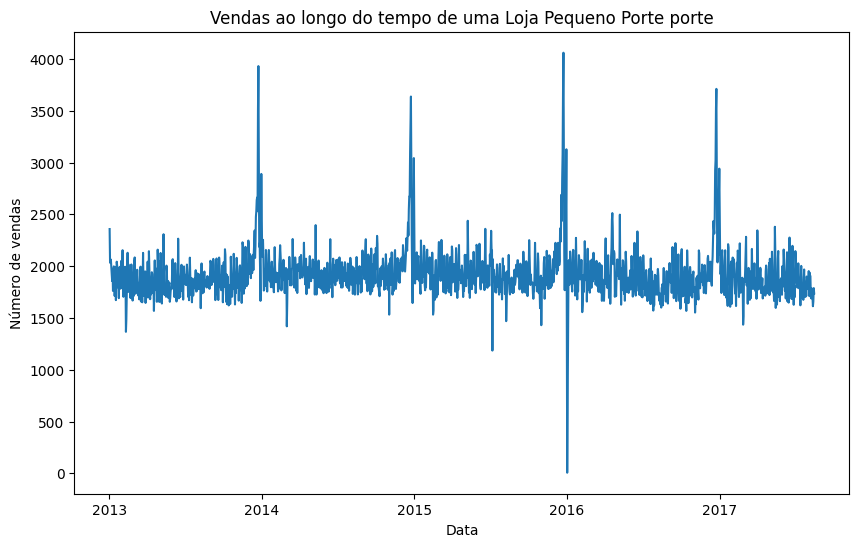

In [52]:
# Visualização dos dados
plt.figure(figsize=(10, 6))
plt.plot(df_sarPP['date'], df_sarPP['transactions'])
plt.title('Vendas ao longo do tempo de uma Loja Pequeno Porte porte')
plt.xlabel('Data')
plt.ylabel('Número de vendas')
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



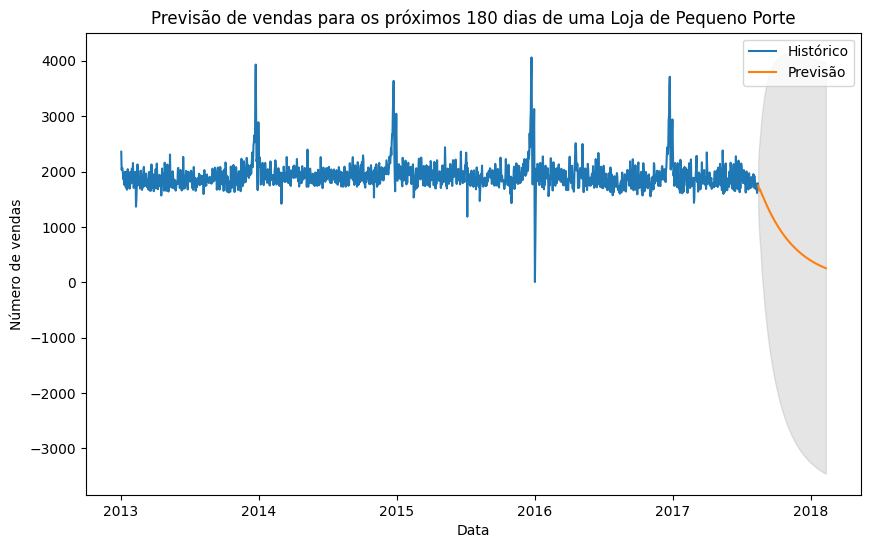

In [53]:
# Ajuste do modelo SARIMA
model = SARIMAX(df_sarPP['transactions'], order=(1, 0, 0), seasonal_order=(1, 0, 0, 7))
result = model.fit()

# Previsão dos próximos 180 dias
forecast = result.get_forecast(steps=180)

# Visualização da previsão
plt.figure(figsize=(10, 6))
plt.plot(df_sarPP['date'], df_sarPP['transactions'], label='Histórico')
plt.plot(pd.date_range(start=df_sarPP['date'].max(), periods=180), forecast.predicted_mean, label='Previsão')
plt.fill_between(pd.date_range(start=df_sarPP['date'].max(), periods=180),
                 forecast.conf_int()['lower transactions'],
                 forecast.conf_int()['upper transactions'], color='gray', alpha=0.2)
plt.title('Previsão de vendas para os próximos 180 dias de uma Loja de Pequeno Porte')
plt.xlabel('Data')
plt.ylabel('Número de vendas')
plt.legend()
pqn_porte_sar = plt.show()